May want to consider scvelo for improved assumptions in the future: https://scvelo.readthedocs.io/getting_started.html
scv also has a function to compute the pseudotime

# **Analysis**

In [165]:
import velocyto as vcy
import scvelo as scv
import numpy as np
import pandas as pd
import scipy as sc
import h5py
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import sys
sys.path.insert(1, '../scripts/') # comment out in python script
from load_environmental_variables import *

# Filter, Normalize, Format

will want to select an appropriate number of pca dimensions for knn based on variance explained

In [43]:
# take the output of velocyto run10x (5k_pbmc_v3_count.loom) and proceed with velocyto.py analyses 
vlm = vcy.VelocytoLoom(local_data_path + 'interim/velocyto/5k_pbmc_v3_count_celltypes.loom')

# set clusters to be the cell type, rather than the clustering from run_velocyto
# this own't replace the vlm.ca['Clusters'], but rather returns a vlm.cluster_labels
vlm.set_clusters(vlm.ca['Cell_Type'])

# filter out cells with low unspliced counts from both S and U<--do before normalization as in Seurat
vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.5))


# we want to be very lenient with gene filtering so that there are many membrane/EC proteins remaining for 
# CCI scoring, go with atleast 0.1 and 1% of respective dimension for now
# this cuts it down from 33k genes to 11k genes
vlm.score_detection_levels(min_expr_counts=round(0.001*vlm.S.shape[0]), 
                           min_cells_express=round(0.01*vlm.S.shape[1]))
vlm.filter_genes(by_detection_levels=True)

# # this means, for now, skip feature selection (HVGs)
# vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
# vlm.filter_genes(by_cv_vs_mean=True)

# log2(psuedo + count/size) normalize the spliced matrix counts 

# S_norm is the fully normalized matrix; S_sz is the size normalized (no log or pseudocount)
vlm._normalize_S(relative_size=vlm.S.sum(0),
             target_size=vlm.S.sum(0).mean())
vlm._normalize_U(relative_size=vlm.U.sum(0),
             target_size=vlm.U.sum(0).mean())

# imput normalized matrices using PCA and KNN, reducing expression matrix sparsity
vlm.perform_PCA(which = 'S_norm')
# returns imputed matrices Sx, Ux (and copies Sx_sz, Ux_uz)
vlm.knn_imputation(k = None, pca_space = True, 
                   n_pca_dims=20, balanced=True, b_sight=3000, b_maxl=1500, n_jobs=25)

# pd.DataFrame(vlm.Sx).equals(pd.DataFrame(vlm.Sx_sz))

# source code makes it pretty clear what is happening here
vlm.fit_gammas()
vlm.predict_U(which_gamma = 'gammas', which_S = 'Sx_sz')
vlm.calculate_velocity()
# returns vlm.delta_S, the shift in gene expression at that delta_t
vlm.calculate_shift(assumption="constant_velocity", delta_t = 1)

vlm.calculate_velocity()
# in this case, delta_t scales the returned delta_S (e.g., if delta_t = 10, each element in delta_S is 10x what 
# it would be if delta_t = 1), as such, it does not effect the extrapolate_cel_at_t output
vlm.calculate_shift(assumption="constant_velocity", delta_t = 1)
# vlm.extrapolate_cell_at_t(delta_t=100)



# Get Convergence Rule for Projection

In [212]:
progress = pd.DataFrame(columns = ['distance_ratio', 'delta_t_ratio', 'distance', 'delta_t'])

max_dt = 0.0001
vlm.extrapolate_cell_at_t(delta_t = max_dt)
change_0 = vlm.Sx_sz_t
distance_0 = 0
progress.loc[0,:] = [float('nan'), float('nan'), float('nan'), max_dt]

t_0 = max_dt
max_dt *= 10
vlm.extrapolate_cell_at_t(delta_t = max_dt)
distance_1 = np.linalg.norm(change_0-vlm.Sx_sz_t)
change0 = vlm.Sx_sz_t
progress.loc[1,:] = [float('nan'), max_dt/t_0, distance_1, max_dt]

counter = 2
while abs(distance_1/distance_0 - max_dt/t_0) >= 0.0001:
    t_0 = max_dt
    max_dt += 1
        
    vlm.extrapolate_cell_at_t(delta_t = max_dt)
    distance_0 = distance_1
    distance_1 = np.linalg.norm(change_0-vlm.Sx_sz_t)
    progress.loc[counter,:] = [distance_1/distance_0, max_dt/t_0, distance_1, max_dt]
    change0 = vlm.Sx_sz_t
    counter += 1

max_dt = round(max_dt)
# generate 100 time points between 0 and max_dt
time_points = np.arange(0, max_dt + max_dt/99, max_dt/99)

/home/hratch/anaconda3/envs/CD8T_RA/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


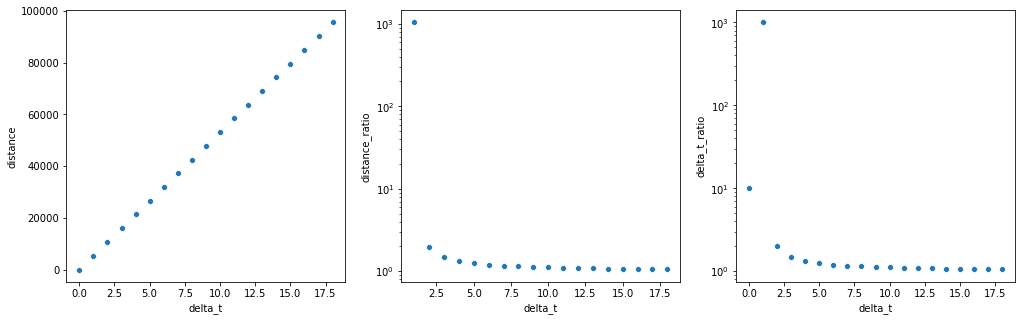

In [226]:
fig, ax = plt.subplots(ncols=3, figsize = (17,5))
g0 = sns.scatterplot(x = 'delta_t', y ='distance', data = progress, ax = ax[0])

g1 = sns.scatterplot(x = 'delta_t', y ='distance_ratio', data = progress, ax = ax[1])
ax[1].set_yscale('log')

g2 = sns.scatterplot(x = 'delta_t', y ='delta_t_ratio', data = progress, ax = ax[2])
ax[2].set_yscale('log')

plt.savefig(local_data_path + 'figures/dt_convergence.pdf', bbox_inches='tight')
plt.savefig(local_data_path + 'figures/dt_convergence.png', bbox_inches='tight')

In [ ]:
# pd.DataFrame(vlm.Sx_sz).equals(pd.DataFrame(vlm.Sx))
# since this returns True, assume vlm.Sx_sz is the expression matrix at t = 0, should double check this is correct
# pd.DataFrame(vlm.Sx_sz).equals(pd.DataFrame(vlm.Sx_sz_t)) # this should not return True (should be changing with dt)

# Project Expression Matrix and Save results

In [6]:
if not os.path.isdir(local_data_path + 'interim/velocyto_analyses/'):
    os.mkdir(local_data_path + 'interim/velocyto_analyses/')

In [ ]:
# assume vlm.Sx_sz is at t = 0, create h5 object
# h5py will create a compressed object containing all the matrices, which can be used to transfer data to others
expression_dt = h5py.File(local_data_path + 'interim/velocyto_analyses/expression_dt.h5', 'w')
expression_dt.create_dataset(str(0), data = vlm.Sx_sz) # expression_over_time = {0: vlm.Sx_sz}

for dt in tqdm(time_points):
    vlm.extrapolate_cell_at_t(delta_t=dt)
    expression_dt.create_dataset(str(dt), data=vlm.Sx_sz_t) # do the projection

expression_dt.close()

# write file with cell names
with open(local_data_path + 'interim/velocyto_analyses/column_names.txt', 'w') as f:
    for name in vlm.ca['CellID']:
        f.write(name + '\n')


# repeat for rownames
with open(local_data_path + 'interim/velocyto_analyses/row_names.txt', 'w') as f:
    for name in vlm.ra['Gene']:
        f.write(name + '\n')

In [ ]:
# save as csv's, which is the format need for input to cell2cell
if not os.path.isdir(local_data_path + 'interim/velocyto_analyses/projected_gene_expression_csvs'):
    os.mkdir(local_data_path + 'interim/velocyto_analyses/projected_gene_expression_csvs/')
    
cell_ids = open(local_data_path + 'interim/velocyto_analyses/column_names.txt').read().splitlines()
gene_names = open(local_data_path + 'interim/velocyto_analyses/row_names.txt').read().splitlines()
expression_dt = h5py.File(local_data_path + 'interim/velocyto_analyses/expression_dt.h5', "r")

for dt in tqdm(expression_dt.keys()):
    expression_df = pd.DataFrame(expression_dt[dt], columns = cell_ids, index = gene_names)
    fn = local_data_path + 'interim/velocyto_analyses/projected_gene_expression_csvs/'
    fn += 'T-' + '{:04d}'.format(int(dt))  + '-Expression.csv'
    expression_df.to_csv(fn)

In [26]:
for dt in tqdm(expression_dt.keys()):
    expression_df = pd.DataFrame(expression_dt[dt], columns = cell_ids, index = gene_names)
    fn = local_data_path + 'interim/velocyto_analyses/projected_gene_expression_csvs/'
    fn += 'T-' + '{:04d}'.format(int(dt))  + '-Expression.csv'
    expression_df.to_csv(fn)

100%|██████████| 100/100 [45:11<00:00, 27.12s/it]


# Get Cell Ordering

In [280]:
# import scvelo as scv

In [229]:
from sklearn.manifold import TSNE
bh_tsne = TSNE(n_jobs=25)
vlm.ts = bh_tsne.fit_transform(vlm.pcs[:, :25])

In [237]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_sight=round(0.01*vlm.Sx_sz.shape[1]), n_jobs = 25)
vlm.calculate_embedding_shift()
vlm.calculate_grid_arrows(n_neighbors=round(0.01*vlm.Sx_sz.shape[1]), n_jobs = 25)

/home/hratch/anaconda3/envs/CD8T_RA/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3319: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


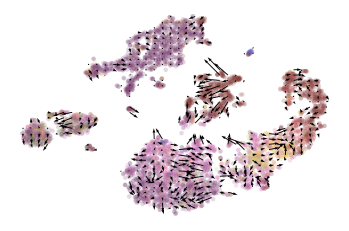

In [274]:
vlm.plot_grid_arrows()

In [277]:
vlm.

IndexError: index 0 is out of bounds for axis 0 with size 0